### Running baseline models

In [70]:
# necessary modules
import pandas as pd
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

from DataPreprocessing.preprocessing_function import preprocess_data
from baseline_models import train_multinomial_logistic_regression, train_decision_tree
from shap_plots import plot_shap_values_DT, plot_shap_values_MLR

### JFK Baseline Models

In [2]:
# import dataset
merged_jfk_df = pd.read_csv('data/complete/JFK_final_df.csv')

# preprocessing
X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk = preprocess_data(merged_jfk_df)

Epoch [10/100], Loss: 2.5724, Accuracy: 0.0207
Epoch [20/100], Loss: 2.4993, Accuracy: 0.0693
Epoch [30/100], Loss: 2.4276, Accuracy: 0.1803
Epoch [40/100], Loss: 2.3574, Accuracy: 0.3407
Epoch [50/100], Loss: 2.2886, Accuracy: 0.5103
Epoch [60/100], Loss: 2.2215, Accuracy: 0.6458
Epoch [70/100], Loss: 2.1560, Accuracy: 0.7313
Epoch [80/100], Loss: 2.0922, Accuracy: 0.7773
Epoch [90/100], Loss: 2.0302, Accuracy: 0.8009
Epoch [100/100], Loss: 1.9700, Accuracy: 0.8132

Training Set Metrics:
Accuracy: 0.8140
Precision: 0.7736
Recall: 0.8140
F1: 0.7888

Test Set Metrics:
Accuracy: 0.7967
Precision: 0.7583
Recall: 0.7967
F1: 0.7722


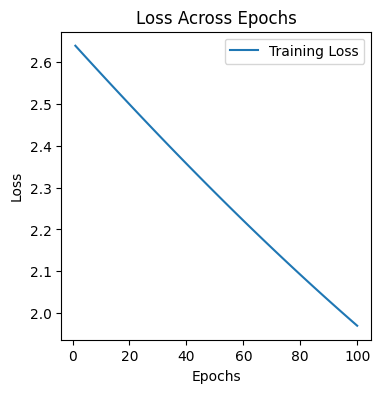

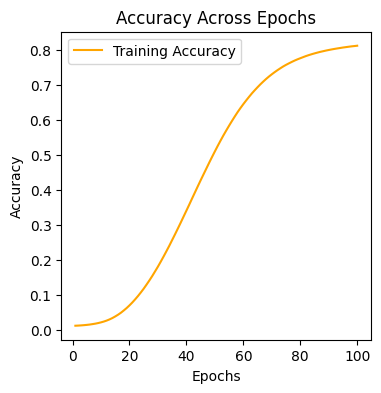

In [3]:
jfk_MLR_model, jfk_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk)

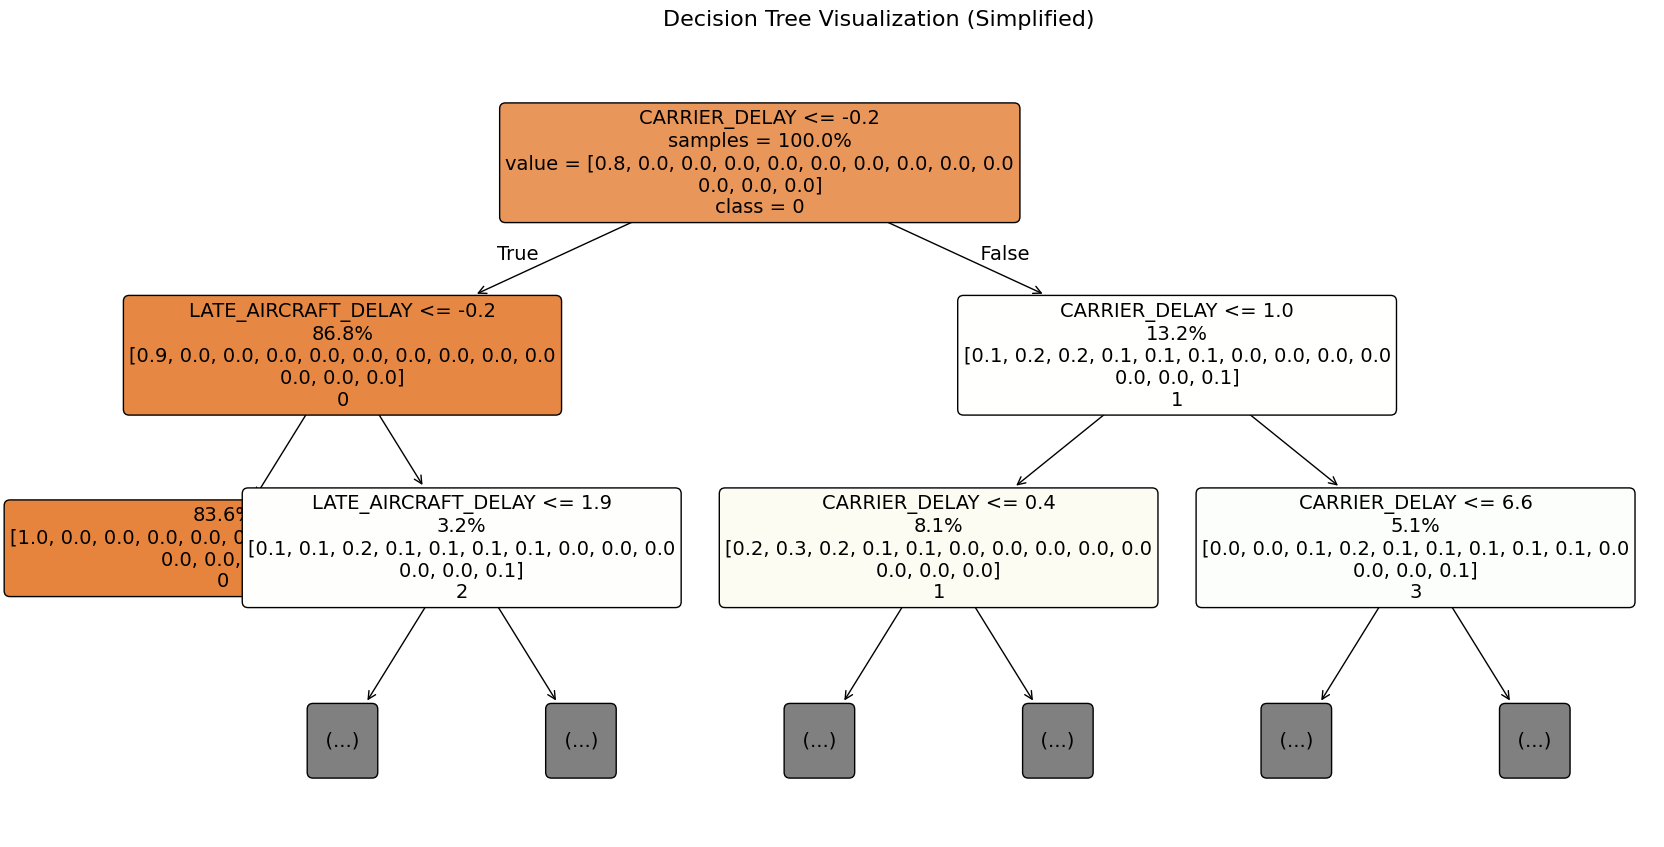

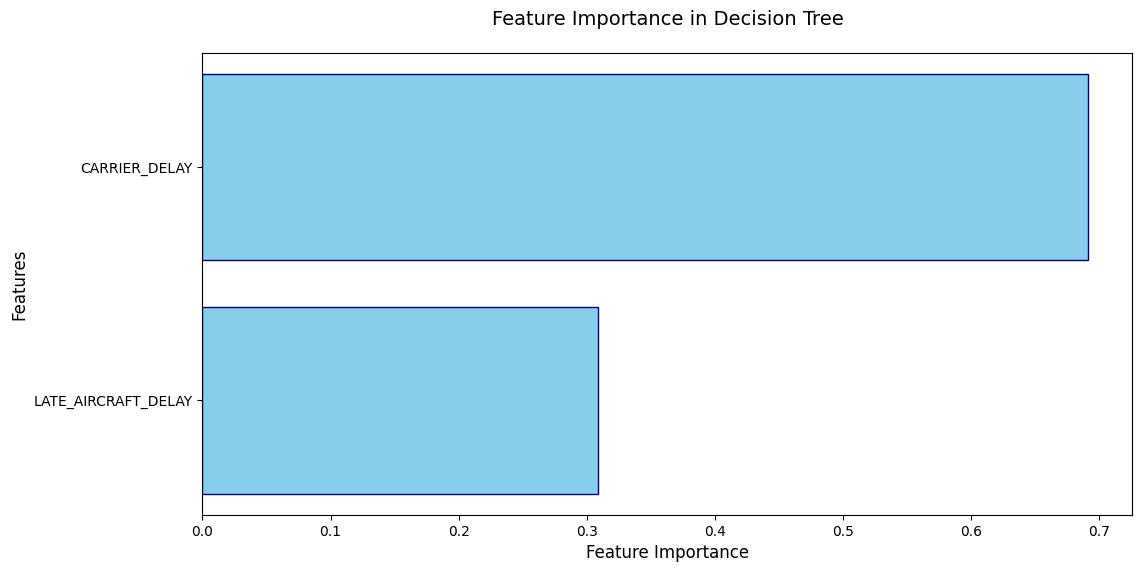

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.8874
Precision: 0.8640
Recall: 0.8874
F1: 0.8745

Test Set Metrics:
Accuracy: 0.8751
Precision: 0.8476
Recall: 0.8751
F1: 0.8605


In [4]:
jfk_DT_model, jfk_metrics_DT = train_decision_tree(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk)

### MIA Baseline Models

In [6]:
# import dataset
merged_mia_df = pd.read_csv('data/complete/MIA_final_df.csv')

# preprocessing
X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia, feature_names_mia = preprocess_data(merged_mia_df)

Epoch [10/100], Loss: 2.5738, Accuracy: 0.1221
Epoch [20/100], Loss: 2.5047, Accuracy: 0.1895
Epoch [30/100], Loss: 2.4369, Accuracy: 0.2789
Epoch [40/100], Loss: 2.3703, Accuracy: 0.3859
Epoch [50/100], Loss: 2.3050, Accuracy: 0.4980
Epoch [60/100], Loss: 2.2412, Accuracy: 0.6006
Epoch [70/100], Loss: 2.1787, Accuracy: 0.6805
Epoch [80/100], Loss: 2.1179, Accuracy: 0.7354
Epoch [90/100], Loss: 2.0585, Accuracy: 0.7681
Epoch [100/100], Loss: 2.0008, Accuracy: 0.7862


c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.7874
Precision: 0.7380
Recall: 0.7874
F1: 0.7591

Test Set Metrics:
Accuracy: 0.7873
Precision: 0.7534
Recall: 0.7873
F1: 0.7680


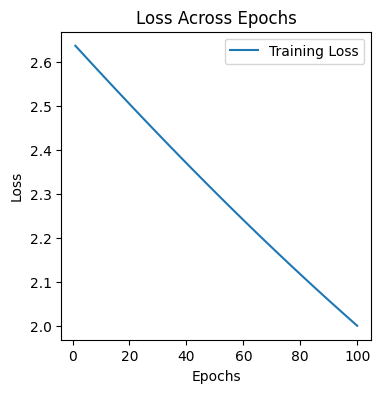

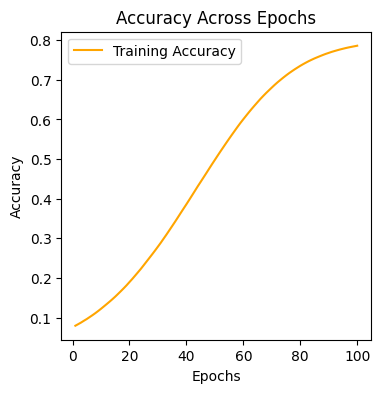

In [7]:
mia_MLR_model, mia_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia)

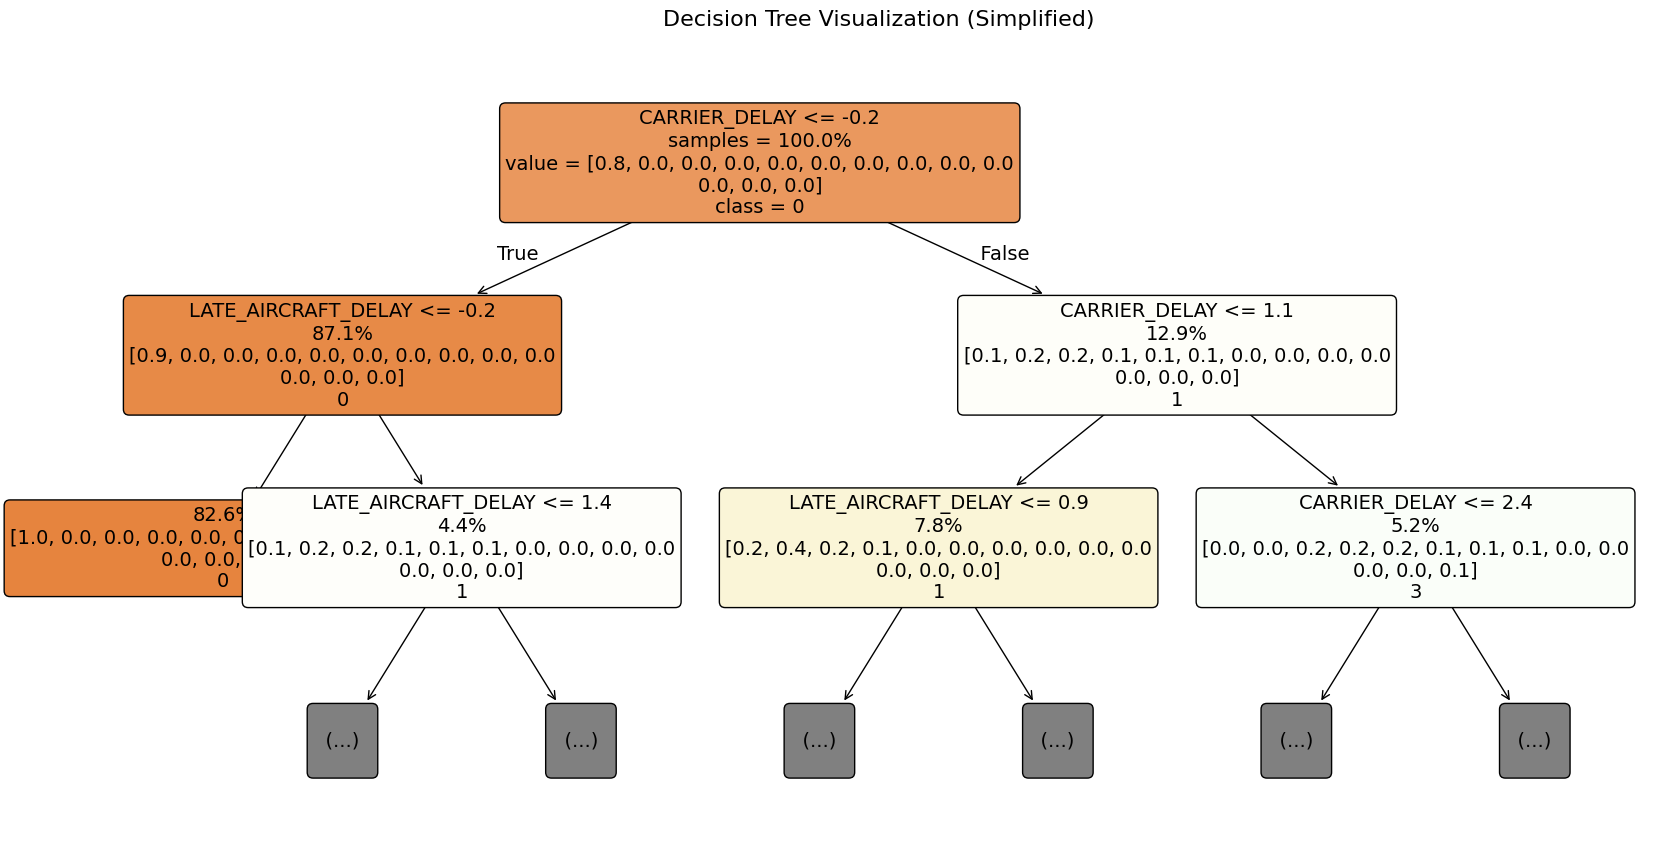

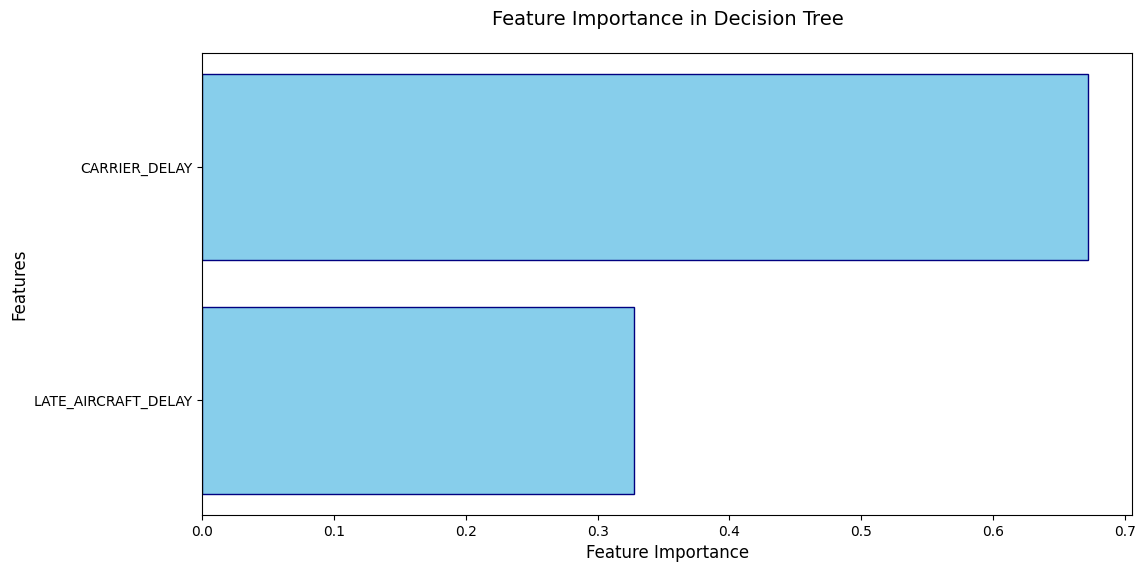


Training Set Metrics:
Accuracy: 0.8878
Precision: 0.8629
Recall: 0.8878
F1: 0.8693

Test Set Metrics:
Accuracy: 0.8821
Precision: 0.8547
Recall: 0.8821
F1: 0.8620


c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
mia_DT_model, mia_metrics_DT = train_decision_tree(X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia, feature_names_mia)

### LAX models

In [9]:
# import dataset
merged_lax_df = pd.read_csv('data/complete/LAX_final_df.csv')

# preprocessing
X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax, feature_names_lax = preprocess_data(merged_lax_df)

Epoch [10/100], Loss: 2.4685, Accuracy: 0.1754
Epoch [20/100], Loss: 2.3985, Accuracy: 0.2738
Epoch [30/100], Loss: 2.3299, Accuracy: 0.3918
Epoch [40/100], Loss: 2.2627, Accuracy: 0.5231
Epoch [50/100], Loss: 2.1970, Accuracy: 0.6470
Epoch [60/100], Loss: 2.1328, Accuracy: 0.7399
Epoch [70/100], Loss: 2.0702, Accuracy: 0.7964
Epoch [80/100], Loss: 2.0093, Accuracy: 0.8245
Epoch [90/100], Loss: 1.9501, Accuracy: 0.8372
Epoch [100/100], Loss: 1.8926, Accuracy: 0.8426

Training Set Metrics:
Accuracy: 0.8430
Precision: 0.7691
Recall: 0.8430
F1: 0.7981

Test Set Metrics:
Accuracy: 0.8210
Precision: 0.7454
Recall: 0.8210
F1: 0.7751


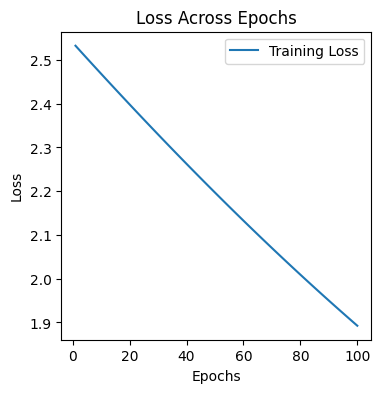

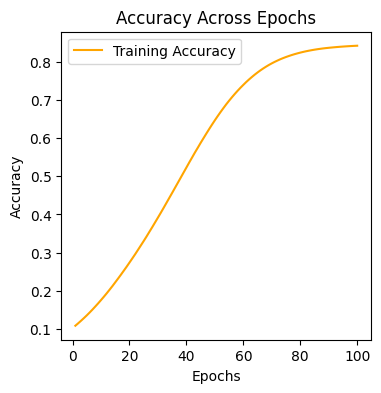

In [10]:
lax_MLR_model, lax_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax)

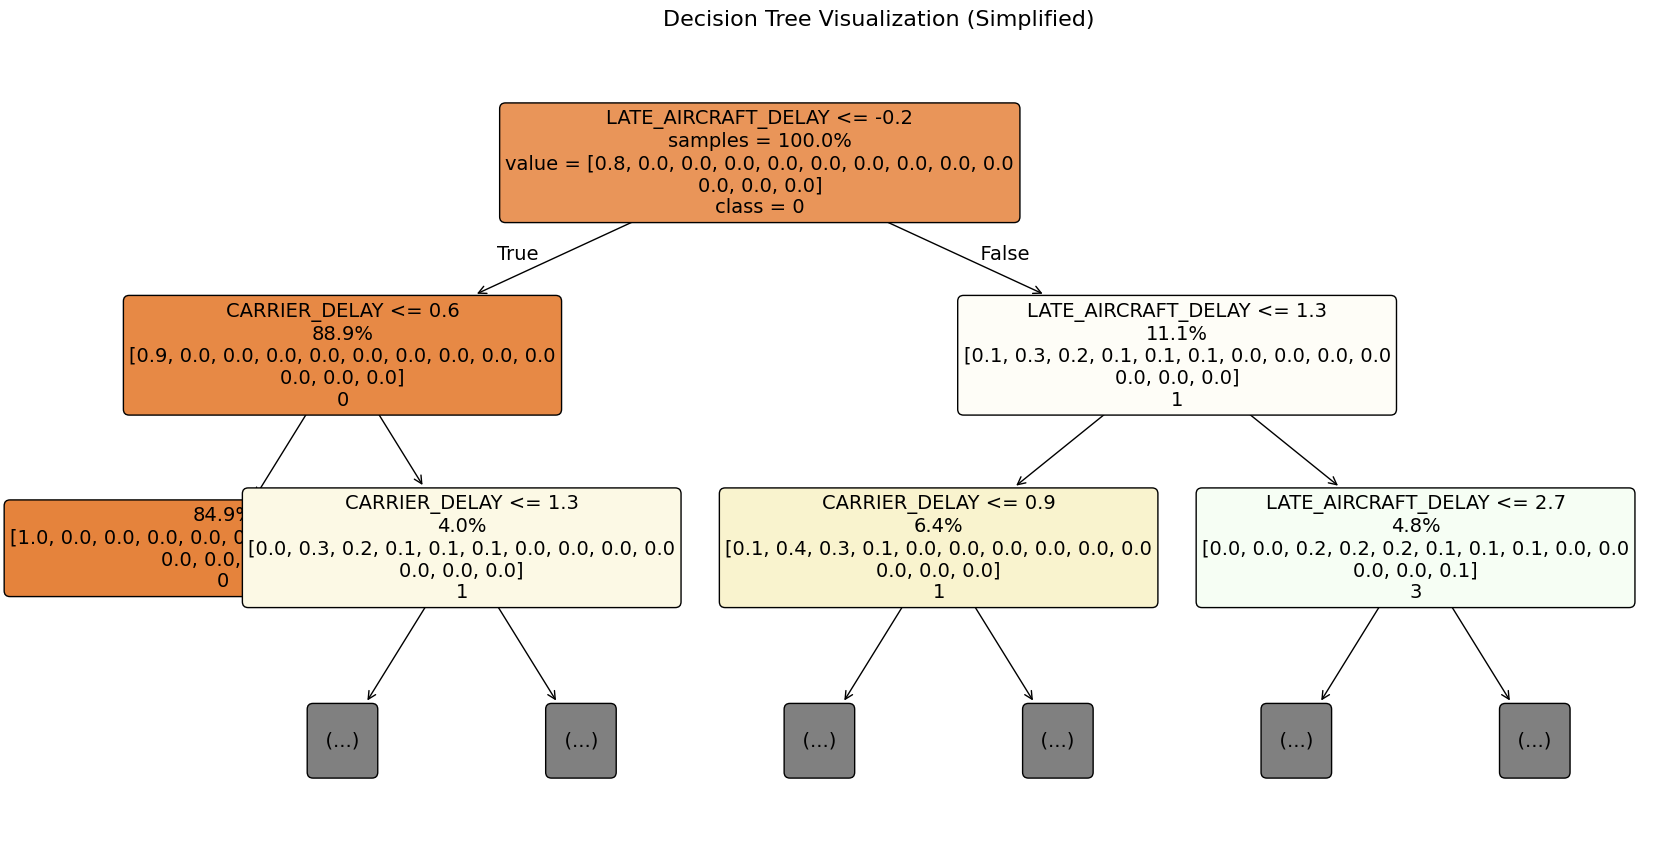

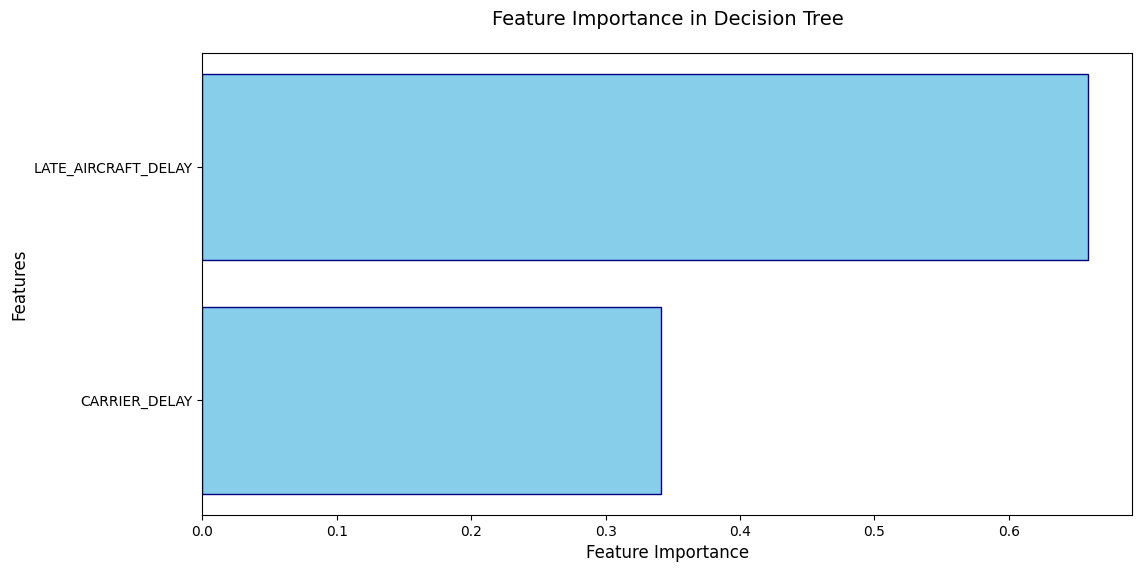

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.9104
Precision: 0.8962
Recall: 0.9104
F1: 0.8999

Test Set Metrics:
Accuracy: 0.8868
Precision: 0.8683
Recall: 0.8868
F1: 0.8732


c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
lax_DT_model, lax_metrics_DT = train_decision_tree(X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax, feature_names_lax)

### EWR Baseline Models

In [13]:
# import dataset
merged_ewr_df = pd.read_csv('data/complete/EWR_final_df.csv')

# preprocessing
X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr, feature_names_ewr = preprocess_data(merged_ewr_df)

Epoch [10/100], Loss: 2.5030, Accuracy: 0.1774
Epoch [20/100], Loss: 2.4359, Accuracy: 0.2790
Epoch [30/100], Loss: 2.3700, Accuracy: 0.3903
Epoch [40/100], Loss: 2.3056, Accuracy: 0.4953
Epoch [50/100], Loss: 2.2426, Accuracy: 0.5847
Epoch [60/100], Loss: 2.1810, Accuracy: 0.6545
Epoch [70/100], Loss: 2.1210, Accuracy: 0.7050
Epoch [80/100], Loss: 2.0626, Accuracy: 0.7400
Epoch [90/100], Loss: 2.0059, Accuracy: 0.7630
Epoch [100/100], Loss: 1.9508, Accuracy: 0.7778

Training Set Metrics:
Accuracy: 0.7790
Precision: 0.7249
Recall: 0.7790
F1: 0.7472

Test Set Metrics:
Accuracy: 0.7723
Precision: 0.7192
Recall: 0.7723
F1: 0.7408


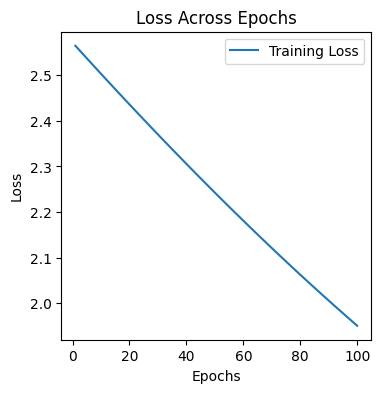

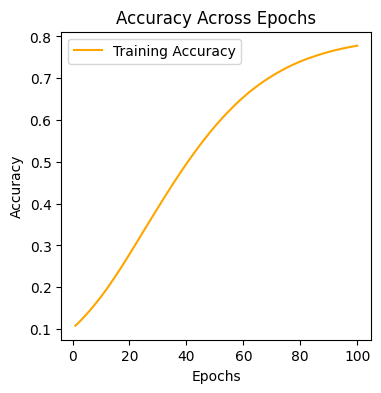

In [14]:
ewr_MLR_model, ewr_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr)

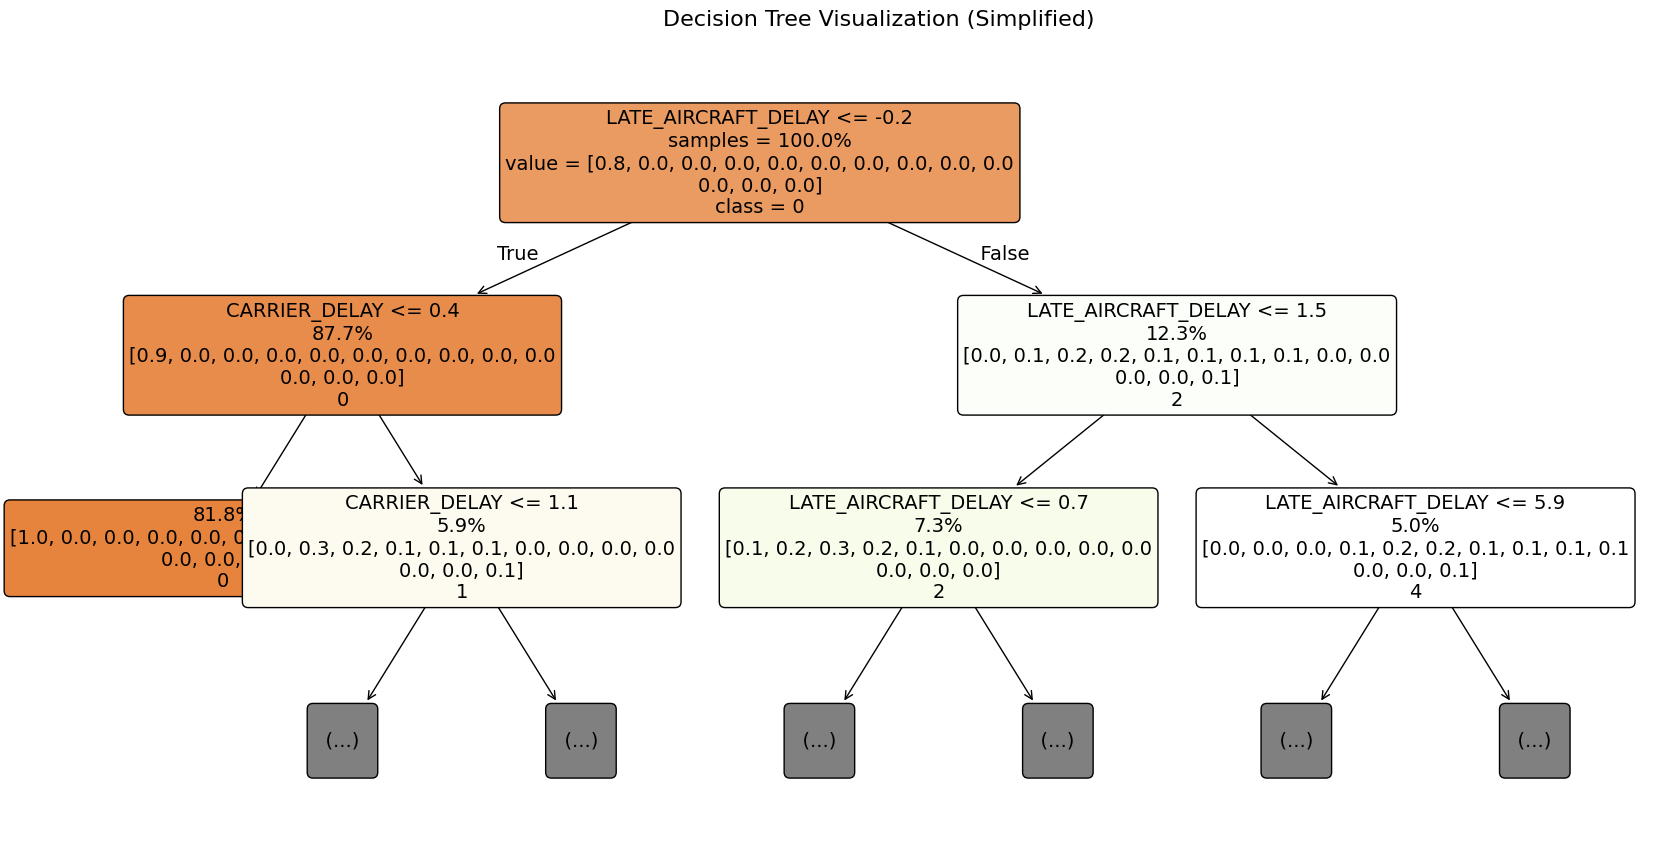

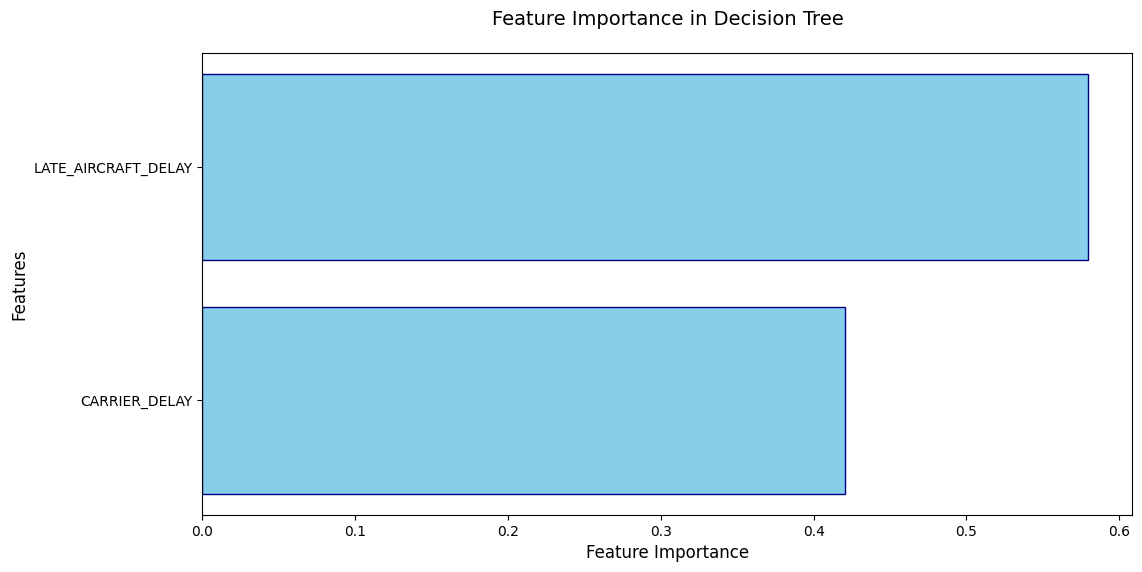

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.8761
Precision: 0.8521
Recall: 0.8761
F1: 0.8597

Test Set Metrics:
Accuracy: 0.8659
Precision: 0.8408
Recall: 0.8659
F1: 0.8481


In [15]:
ewr_DT_model, ewr_metrics_DT = train_decision_tree(X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr, feature_names_ewr)

### ORD Baseline Models

In [16]:
# import dataset
merged_ord_df = pd.read_csv('data/complete/ORD_final_df.csv')

# preprocessing
X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord, feature_names_ord = preprocess_data(merged_ord_df)

Epoch [10/100], Loss: 2.4891, Accuracy: 0.2514
Epoch [20/100], Loss: 2.4250, Accuracy: 0.3629
Epoch [30/100], Loss: 2.3620, Accuracy: 0.4859
Epoch [40/100], Loss: 2.3003, Accuracy: 0.6019
Epoch [50/100], Loss: 2.2399, Accuracy: 0.6975
Epoch [60/100], Loss: 2.1809, Accuracy: 0.7554
Epoch [70/100], Loss: 2.1233, Accuracy: 0.7808
Epoch [80/100], Loss: 2.0671, Accuracy: 0.7899
Epoch [90/100], Loss: 2.0125, Accuracy: 0.7931
Epoch [100/100], Loss: 1.9594, Accuracy: 0.7943

Training Set Metrics:
Accuracy: 0.7943
Precision: 0.6837
Recall: 0.7943
F1: 0.7312

Test Set Metrics:
Accuracy: 0.8237
Precision: 0.7364
Recall: 0.8237
F1: 0.7743


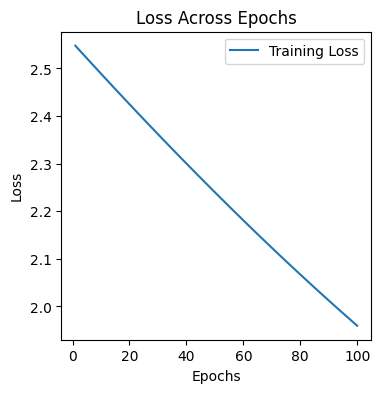

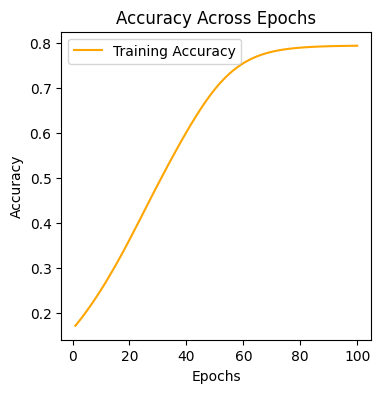

In [17]:
ord_MLR_model, ord_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord)

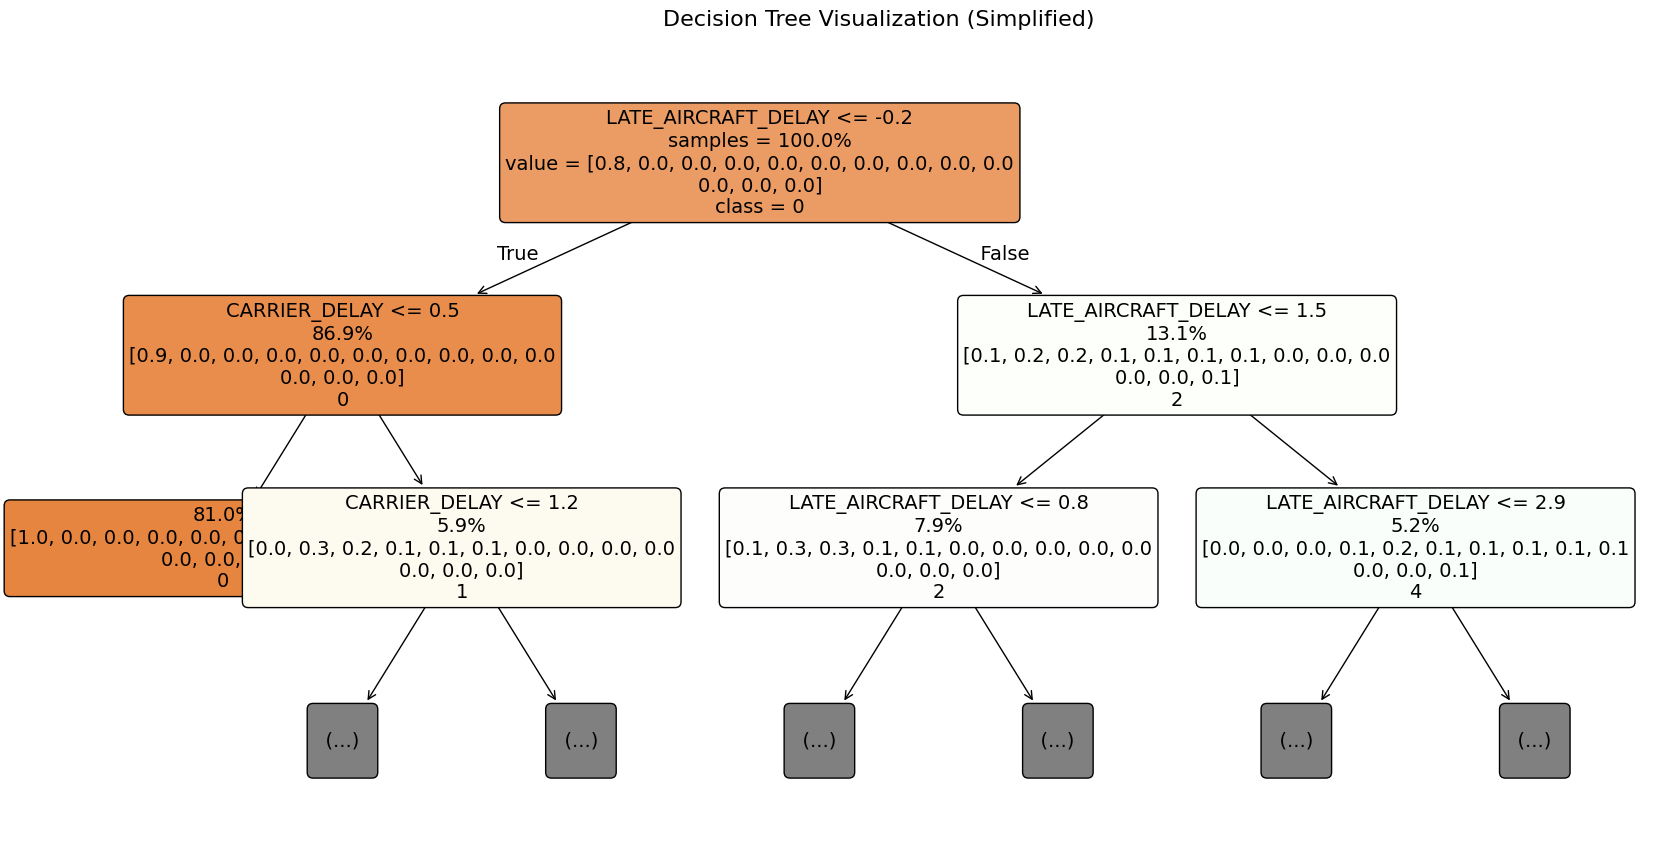

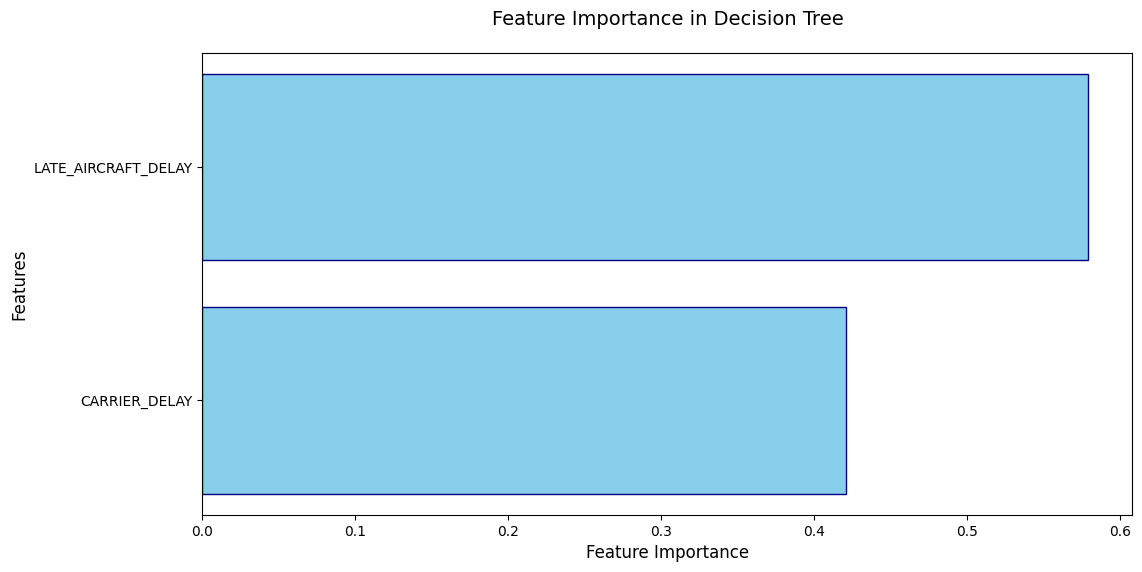

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.8710
Precision: 0.8495
Recall: 0.8710
F1: 0.8558

Test Set Metrics:
Accuracy: 0.8865
Precision: 0.8689
Recall: 0.8865
F1: 0.8736


c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
ord_DT_model, ord_metrics_DT = train_decision_tree(X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord, feature_names_ord)

### SHAP Analysis for Baselines

In [72]:
# jfk
plot_shap_values_DT(jfk_DT_model, X_train_torch_jfk, X_test_torch_jfk, feature_names_jfk, 'jfk', 'DT_shap_jfk.png', sample_size=2000)

SHAP summary plot generated and saved as 'DT_shap_jfk.png' for JFK (Sampled 2000 points)


In [73]:
# mia
plot_shap_values_DT(mia_DT_model, X_train_torch_mia, X_test_torch_mia, feature_names_mia, 'mia', 'DT_shap_mia.png', sample_size=2000)

SHAP summary plot generated and saved as 'DT_shap_mia.png' for MIA (Sampled 2000 points)


In [74]:
# lax
plot_shap_values_DT(lax_DT_model, X_train_torch_lax, X_test_torch_lax, feature_names_lax, 'lax', 'DT_shap_lax.png', sample_size=2000)

SHAP summary plot generated and saved as 'DT_shap_lax.png' for LAX (Sampled 2000 points)


In [75]:
# ewr
plot_shap_values_DT(ewr_DT_model, X_train_torch_ewr, X_test_torch_ewr, feature_names_ewr, 'ewr', 'DT_shap_ewr.png', sample_size=2000)

SHAP summary plot generated and saved as 'DT_shap_ewr.png' for EWR (Sampled 2000 points)


In [76]:
# ord
plot_shap_values_DT(ord_DT_model, X_train_torch_ord, X_test_torch_ord, feature_names_ord, 'ord', 'DT_shap_ord.png', sample_size=2000)

SHAP summary plot generated and saved as 'DT_shap_ord.png' for ORD (Sampled 2000 points)


MLR

In [77]:
# jfk
plot_shap_values_MLR(jfk_MLR_model, X_train_torch_jfk, X_test_torch_jfk, feature_names_jfk, location_code="jfk", save_path="MLR_shap_jfk.png", sample_size=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [57:26<00:00,  1.72s/it] 


SHAP summary plot generated and saved as 'MLR_shap_jfk.png' for JFK (Sampled 2000 points)


In [79]:
# mia
plot_shap_values_MLR(mia_MLR_model, X_train_torch_mia, X_test_torch_mia, feature_names_mia, location_code="mia", save_path="MLR_shap_mia.png", sample_size=2000)

100%|██████████| 2000/2000 [44:22<00:00,  1.33s/it] 


SHAP summary plot generated and saved as 'MLR_shap_mia.png' for MIA (Sampled 2000 points)


In [80]:
# lax
plot_shap_values_MLR(lax_MLR_model, X_train_torch_lax, X_test_torch_lax, feature_names_lax, location_code="lax", save_path="MLR_shap_lax.png", sample_size=2000)

100%|██████████| 2000/2000 [55:48<00:00,  1.67s/it]  


SHAP summary plot generated and saved as 'MLR_shap_lax.png' for LAX (Sampled 2000 points)


In [81]:
# ewr
plot_shap_values_MLR(ewr_MLR_model, X_train_torch_ewr, X_test_torch_ewr, feature_names_ewr, location_code="ewr", save_path="MLR_shap_ewr.png", sample_size=2000)

100%|██████████| 2000/2000 [1:39:43<00:00,  2.99s/it]    


SHAP summary plot generated and saved as 'MLR_shap_ewr.png' for EWR (Sampled 2000 points)


In [82]:
# ord
plot_shap_values_MLR(ord_MLR_model, X_train_torch_ord, X_test_torch_ord, feature_names_ord, location_code="ord", save_path="MLR_shap_ord.png", sample_size=2000)

100%|██████████| 2000/2000 [1:28:06<00:00,  2.64s/it]


SHAP summary plot generated and saved as 'MLR_shap_ord.png' for ORD (Sampled 2000 points)
